<a href="https://colab.research.google.com/github/lugoll/Coursera_Capstone/blob/main/Similarities%20of%20the%20neighborhood%20structure%20-%20Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Similarities of the neighborhood structure of Capital Cities (2)

In this Notebook, the data aquired [here](https://https://github.com/lugoll/Coursera_Capstone/blob/main/Similarities%20of%20the%20neighborhood%20structure%20-%20Data.ipynb) will be analyzed by different statistical methods and results will be visualized.

Full Report: https://github.com/lugoll/Coursera_Capstone/blob/main/Report.pdf

In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans

!pip install geopy > /dev/null
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

!pip install folium > /dev/null
import folium

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print("Imports successful")

Imports successful


In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/lugoll/Coursera_Capstone/main/prepared_venues_newyork_toronto.csv')
print(df.shape)
df.drop('Unnamed: 0', 1, inplace=True)
df.head()

(12248, 9)


,City,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,NewYork,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,NewYork,Wakefield,40.894705,-73.847201,Rite Aid,40.896649,-73.844846,Pharmacy
2,NewYork,Wakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,NewYork,Wakefield,40.894705,-73.847201,Walgreens,40.896528,-73.844700,Pharmacy
4,NewYork,Wakefield,40.894705,-73.847201,Dunkin',40.890459,-73.849089,Donut Shop


## Statistical Analysis

One hot encode categories for analysis, which gives us 457 rows of slightly different categories.

In [3]:
df_onehot = pd.get_dummies(df[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood and city column back to dataframe
df_onehot['Neighborhood'] = df['Neighborhood'] 
df_onehot['City'] = df['City'] 

# move neighborhood column to the first column
fixed_columns = list(df_onehot.columns)
fixed_columns.remove('Neighborhood')
fixed_columns.remove('City')
fixed_columns = ['City', 'Neighborhood'] + fixed_columns

df_onehot = df_onehot[fixed_columns]
df_onehot.head()

,City,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,...,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,NewYork,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NewYork,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NewYork,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,NewYork,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,NewYork,Wakefield,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Compare both cities by different categories of venues

Get the absolute numbers of categories per city

In [4]:
df_city = df_onehot.drop('Neighborhood', 1)
city_abs = df_city.groupby('City').sum().reset_index()
city_abs.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,...,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,NewYork,8.0,1.0,2.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,163.0,8.0,0.0,2.0,10.0,9.0,48.0,5.0,19.0,2.0,49.0,15.0,1.0,4.0,2.0,1.0,0.0,5.0,26.0,1.0,112.0,228.0,146.0,225.0,20.0,3.0,10.0,0.0,1.0,...,11.0,2.0,1.0,89.0,36.0,1.0,4.0,1.0,20.0,2.0,5.0,2.0,2.0,14.0,2.0,13.0,1.0,18.0,14.0,2.0,4.0,2.0,1.0,39.0,1.0,1.0,23.0,11.0,41.0,1.0,2.0,1.0,2.0,1.0,5.0,68.0,88.0,12.0,23.0,80.0
1,Toronto,2.0,0.0,1.0,0.0,2.0,1.0,1.0,2.0,2.0,1.0,27.0,3.0,5.0,0.0,0.0,0.0,14.0,2.0,3.0,0.0,13.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,1.0,5.0,41.0,24.0,33.0,4.0,2.0,0.0,4.0,0.0,...,1.0,0.0,0.0,22.0,14.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,0.0,6.0,0.0,4.0,1.0,0.0,0.0,0.0,0.0,16.0,0.0,0.0,3.0,0.0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,10.0,0.0,1.0,6.0,13.0


The absolute numbers of New York are much higher due to the higher amount of venues in the city (round about 10000 compared to 2000). So, let's work with the relative proportion of the categories per city.

In [5]:
city_rel = df_city.groupby('City').mean().reset_index()
city_rel.head()

,City,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,...,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,NewYork,0.000791,0.000099,0.000198,0.000593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000099,0.016119,0.000791,0.000000,0.000198,0.000989,0.00089,0.004747,0.000494,0.001879,0.000198,0.004846,0.001483,0.000099,0.000396,0.000198,0.000099,0.000000,0.000494,0.002571,0.000099,0.011076,0.022547,0.014438,0.022251,0.001978,0.000297,0.000989,0.000000,0.000099,...,0.001088,0.000198,0.000099,0.008801,0.003560,0.000099,0.000396,0.000099,0.001978,0.000198,0.000494,0.000198,0.000198,0.001384,0.000198,0.001286,0.000099,0.001780,0.001384,0.000198,0.000396,0.000198,0.000099,0.003857,0.000099,0.000099,0.002275,0.001088,0.004055,0.000099,0.000198,0.000099,0.000198,0.000099,0.000494,0.006725,0.008703,0.001187,0.002275,0.007911
1,Toronto,0.000936,0.000000,0.000468,0.000000,0.000936,0.000468,0.000468,0.000936,0.000936,0.000468,0.012640,0.001404,0.002341,0.000000,0.000000,0.00000,0.006554,0.000936,0.001404,0.000000,0.006086,0.002809,0.000000,0.000000,0.000000,0.000468,0.000468,0.000000,0.000936,0.000468,0.002341,0.019195,0.011236,0.015449,0.001873,0.000936,0.000000,0.001873,0.000000,...,0.000468,0.000000,0.000000,0.010300,0.006554,0.000000,0.000000,0.000468,0.000468,0.000000,0.000000,0.000000,0.000000,0.001404,0.000000,0.002809,0.000000,0.001873,0.000468,0.000000,0.000000,0.000000,0.000000,0.007491,0.000000,0.000000,0.001404,0.000000,0.005150,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,0.004682,0.000000,0.000468,0.002809,0.006086


Taking the 15 most occuring categories of each city


In [6]:
new_york_top_categories = np.array(city_rel.iloc[0,1:].transpose().astype(float).nlargest(15).index)
toronto_top_categories = np.array(city_rel.iloc[1,1:].transpose().astype(float).nlargest(15).index)

both_unique_categories = set(list(new_york_top_categories) + list(toronto_top_categories))
common_top_categories = set([c for c in new_york_top_categories if c in toronto_top_categories] + [c for c in toronto_top_categories if c in new_york_top_categories])
ny_only_top_categories = [c for c in new_york_top_categories if c not in common_top_categories]
to_only_top_categories = [c for c in toronto_top_categories if c not in common_top_categories]

new_york = city_rel.loc[0,list(both_unique_categories)]
toronto = city_rel.loc[1,list(both_unique_categories)]

print("Number of common top categories: {}".format(len(common_top_categories)))
print("Number of unique top categories per city: {}".format(len(ny_only_top_categories)))

print("\nCommon Cateogries of both cities:\t{}".format(', '.join(sorted(common_top_categories))))
print("Top Categories of New York:\t\t{}".format(', '.join(sorted(ny_only_top_categories))))
print("Top Categories of Toronto:\t\t{}".format(', '.join(sorted(to_only_top_categories))))

Number of common top categories: 9
Number of unique top categories per city: 6

Common Cateogries of both cities:	American Restaurant, Bakery, Bar, Café, Coffee Shop, Italian Restaurant, Park, Pizza Place, Sandwich Place
Top Categories of New York:		Chinese Restaurant, Deli / Bodega, Donut Shop, Grocery Store, Mexican Restaurant, Pharmacy
Top Categories of Toronto:		Clothing Store, Gym, Hotel, Japanese Restaurant, Restaurant, Sushi Restaurant


Draw the results

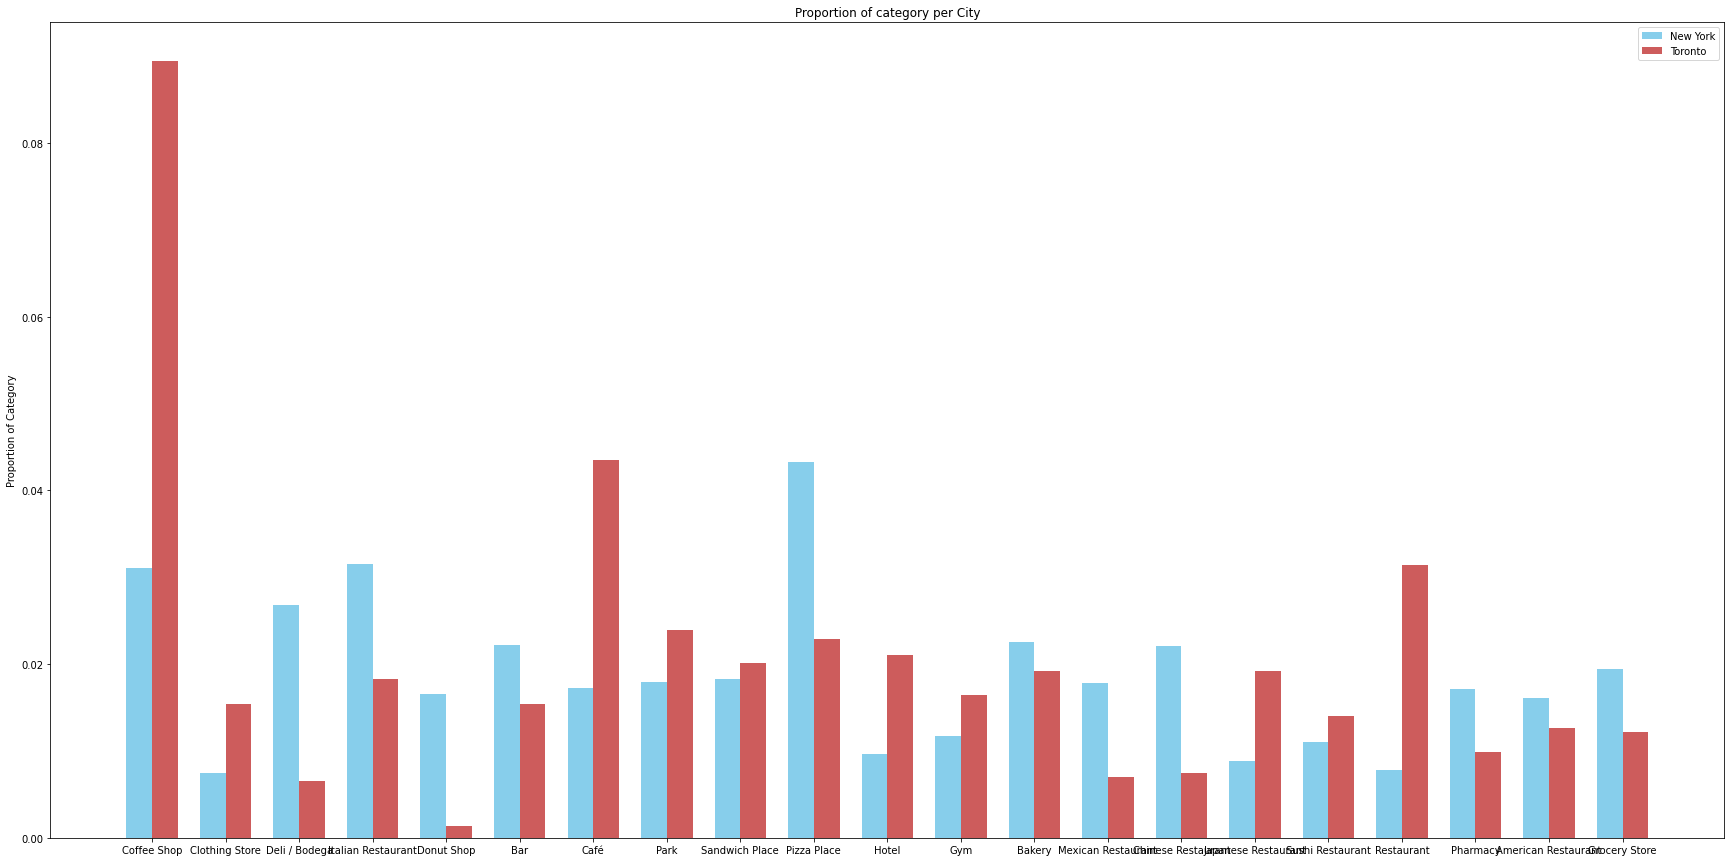

In [7]:
labels = list(both_unique_categories)
x = np.arange(len(labels))  # the label locations
width = 0.35  

fig, ax = plt.subplots(figsize=(30, 15))
rects1 = ax.bar(x - width/2, new_york, width, color='SkyBlue', label='New York')
rects2 = ax.bar(x + width/2, toronto, width, color='IndianRed', label='Toronto')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Proportion of Category')
ax.set_title('Proportion of category per City')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

So, there are some similarities in the occurement of various venue categories in both cities. Nine of the Top 15 categories of both cities are equal and 6 categories per city are only in the top 15 in one city. At the chart we see, that the proportion of most categories are quite equal, but we also see, that for instance Coffee Shop and Cafe are more present in Toronto, whereas Donut Shops and Pizza Places are mor e present in New York. This shows, that it might be of interest to explore the date further for similarities of both cities.

## Machine Learning Analysis 

Now the data will be clustered by K-means clustering algorithmus.

Prepare Dataset:

In [8]:
city_map = {
    'NewYork': df_onehot[['City', 'Neighborhood']].loc[df_onehot['City'] == 'NewYork']['Neighborhood'].unique(),
    'Toronto': df_onehot[['City', 'Neighborhood']].loc[df_onehot['City'] == 'Toronto']['Neighborhood'].unique(),
}

print("Count by city_map dictionary: {}".format(len(list(city_map['NewYork']) + list(city_map['Toronto']))))
print("Count by df_onhot unique method: {}".format(df_onehot['Neighborhood'].unique().shape[0]))

Count by city_map dictionary: 398
Count by df_onhot unique method: 397


It seems there is an equal named neighborhood in both cities. So, lets find them.

In [9]:
equal = ''

for n in city_map['NewYork']:
  if n in city_map['Toronto']:
    equal = n
    break

equal

'Rosedale'

Now Fix the equal named neighborhood

In [10]:
df_onehot_fixed = df_onehot.copy()
df_onehot_fixed.loc[(df_onehot_fixed['Neighborhood'] == equal) & (df_onehot_fixed['City'] == 'NewYork'),'Neighborhood'] = 'Rosedale - NY'
df_onehot_fixed.loc[(df_onehot_fixed['Neighborhood'] == equal) & (df_onehot_fixed['City'] == 'Toronto'),'Neighborhood'] = 'Rosedale - TO'

city_map = {
    'NewYork': df_onehot_fixed[['City', 'Neighborhood']].loc[df_onehot['City'] == 'NewYork']['Neighborhood'].unique(),
    'Toronto': df_onehot_fixed[['City', 'Neighborhood']].loc[df_onehot['City'] == 'Toronto']['Neighborhood'].unique(),
}

df_onehot_fixed['Neighborhood'].unique().shape[0]

398

Take the average of every category per neighborhood


In [11]:
df_mean = df_onehot_fixed.groupby('Neighborhood').mean().reset_index()
df_mean.head()

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Bath House,...,Tennis Court,Tennis Stadium,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tibetan Restaurant,Tiki Bar,Toll Plaza,Tourist Information Center,Toy / Game Store,Track,Trail,Train,Train Station,Turkish Restaurant,Udon Restaurant,Used Bookstore,Vape Store,Varenyky restaurant,Vegetarian / Vegan Restaurant,Venezuelan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Waste Facility,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Allerton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Annadale,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.181818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arden Heights,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Run k-means to cluster the neighborhood into three clusters.


In [12]:
# set number of clusters
kclusters = 3

df_mean_clustering = df_mean.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=128).fit(df_mean_clustering)

# check cluster labels generated for each row in the dataframe
len(kmeans.labels_)

398

Insert Labels to Neighborhoods

In [13]:
df_mean.insert(0, 'Cluster Labels', kmeans.labels_)
labeled_neighborhoods = df_mean[['Cluster Labels', 'Neighborhood']]
labeled_neighborhoods.head()

,Cluster Labels,Neighborhood
0,1,Agincourt
1,2,"Alderwood, Long Branch"
2,2,Allerton
3,2,Annadale
4,2,Arden Heights


Last add the coordinates for neighborhoods

In [14]:
coordinates = df[['Neighborhood','Neighborhood Latitude', 'Neighborhood Longitude']].groupby('Neighborhood').mean()
coordinates

,Neighborhood Latitude,Neighborhood Longitude
Neighborhood,,
Agincourt,43.794200,-79.262029
"Alderwood, Long Branch",43.602414,-79.543484
Allerton,40.865788,-73.859319
Annadale,40.538114,-74.178549
Arden Heights,40.549286,-74.185887
...,...,...
Woodrow,40.541968,-74.205246
Woodside,40.746349,-73.901842
York Mills West,43.752758,-79.400049


In [15]:
labeled_neighborhoods = labeled_neighborhoods.merge(coordinates, on='Neighborhood')
labeled_neighborhoods.head()

,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,1,Agincourt,43.794200,-79.262029
1,2,"Alderwood, Long Branch",43.602414,-79.543484
2,2,Allerton,40.865788,-73.859319
3,2,Annadale,40.538114,-74.178549
4,2,Arden Heights,40.549286,-74.185887


Add City back to neighborhoods

In [16]:
labeled_neighborhoods.insert(0, 'City', pd.Series(dtype='object'))

def add_city(row):
  if row['Neighborhood'] in city_map['NewYork']:
    row['City'] = 'NewYork'
  elif row['Neighborhood'] in city_map['Toronto']:
    row['City'] = 'Toronto'
  return row

labeled_neighborhoods = labeled_neighborhoods.apply(add_city, 1)

In [17]:
labeled_neighborhoods.head()

,City,Cluster Labels,Neighborhood,Neighborhood Latitude,Neighborhood Longitude
0,Toronto,1,Agincourt,43.794200,-79.262029
1,Toronto,2,"Alderwood, Long Branch",43.602414,-79.543484
2,NewYork,2,Allerton,40.865788,-73.859319
3,NewYork,2,Annadale,40.538114,-74.178549
4,NewYork,2,Arden Heights,40.549286,-74.185887


## Visualize Neighborhood Results

Split Dataset into cities

In [18]:
toronto_label = labeled_neighborhoods[labeled_neighborhoods['City'] == 'Toronto']
newyork_label = labeled_neighborhoods.loc[labeled_neighborhoods['City'] == 'NewYork']

### Toronto

In [19]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="ny_explorer")
to_location = geolocator.geocode(address)
to_latitude = to_location.latitude
to_longitude = to_location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(to_latitude, to_longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


Create Map with labled Neighborhoods

In [20]:
map_clusters = folium.Map(location=[to_latitude, to_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_label['Neighborhood Latitude'], toronto_label['Neighborhood Longitude'], toronto_label['Neighborhood'], toronto_label['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### New York

In [21]:
address = 'New York City, United States'

geolocator = Nominatim(user_agent="ny_explorer")
ny_location = geolocator.geocode(address)
ny_latitude = ny_location.latitude
ny_longitude = ny_location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(ny_latitude, ny_longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create Map with labled Neighborhoods

In [22]:
map_clusters = folium.Map(location=[ny_latitude, ny_longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(newyork_label['Neighborhood Latitude'], newyork_label['Neighborhood Longitude'], newyork_label['Neighborhood'], newyork_label['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters